In [1]:
from brix import Indicator, Handler
import OpenCity
import geopandas as gpd
from shapely.geometry import Point, shape
import json
import requests
import urllib

In [18]:
table_name='volpe_2'
geom_type='block_group'

model_radius=5000
reference_radius=2500

- Create the handler
- Get the geogrid
- Identify the state
- Get the state geometry
- find the overlap
- Assign the sim, model, reference zones
- Append the grid "zones" to the actual zones (if the zones properties are updated in one indicator, will they be updated for all?)

- all the above in a world object?

In [19]:
h=Handler(table_name)

In [20]:
# geogrid_data=h.get_geogrid_data(include_geometries=True)

In [21]:

# geogrid=geogrid_data.GEOGRID

In [22]:
# geogrid=h.get_GEOGRID()
# geom = [f['geometry'] for f in geogrid['features']]
# geogrid_gdp=gpd.GeoDataFrame({'geometry':geom})

In [23]:
get_url='https://cityio.media.mit.edu/api/table/'+table_name
with urllib.request.urlopen(get_url+'/GEOGRID') as url:
    geogrid=gpd.read_file(url.read().decode())

centroids=geogrid['geometry'].centroid
geogrid['x_centroid']=[c.x for c in centroids]
geogrid['y_centroid']=[c.y for c in centroids]
geogrid

<ipython-input-23-e3ea8eae3bb9>:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids=geogrid['geometry'].centroid


,height,id,interactive,name,geometry,x_centroid,y_centroid
0,20,0,Web,Low Income housing,"POLYGON ((-71.08855 42.36884, -71.08860 42.368...",-71.088442,42.368725
1,4,1,Web,Industrial,"POLYGON ((-71.08829 42.36881, -71.08833 42.368...",-71.088179,42.368691
2,4,2,Web,Industrial,"POLYGON ((-71.08802 42.36877, -71.08807 42.368...",-71.087915,42.368657
3,10,3,Web,Campus,"POLYGON ((-71.08776 42.36874, -71.08781 42.368...",-71.087652,42.368623
4,4,4,Web,Residential,"POLYGON ((-71.08750 42.36870, -71.08754 42.368...",-71.087389,42.368588
...,...,...,...,...,...,...,...
1844,4,1844,Web,Retail,"POLYGON ((-71.08050 42.35934, -71.08054 42.359...",-71.080387,42.359230
1845,4,1845,Web,Residential Low Density,"POLYGON ((-71.08023 42.35931, -71.08028 42.359...",-71.080124,42.359195
1846,4,1846,Web,Retail,"POLYGON ((-71.07997 42.35928, -71.08002 42.359...",-71.079861,42.359161
1847,10,1847,Web,Campus,"POLYGON ((-71.07971 42.35924, -71.07975 42.359...",-71.079598,42.359127


In [24]:
def init_geogrid(table_name, interactive_zone=None):
    """
    initialises the available types on the front-end to a default list from text file
    initialises the GEOGRIDDATA to all "None"
    """

    get_url='https://cityio.media.mit.edu/api/table/'+table_name
    post_url='https://cityio.media.mit.edu/api/table/update/'+table_name
    with urllib.request.urlopen(get_url+'/GEOGRID') as url:
        geogrid=json.loads(url.read().decode()) 
    default_types=json.load(open('data/default_types.json'))
    geogrid['properties']['types']=default_types

    if interactive_zone is not None:
        with urllib.request.urlopen(get_url+'/GEOGRID') as url:
            geogrid_gpd=gpd.read_file(url.read().decode())
        geogrid_intersect_interactive=gpd.overlay(geogrid_gpd, interactive_zone)
        intersect_ids=geogrid_intersect_interactive['id'].values
    else:
        intersect_ids=list(range(len(geogrid['features'])))

    for i in range(len(geogrid['features'])):
        geogrid['features'][i]['properties']['name']='None'
        geogrid['features'][i]['properties']['height']=[0]
        if i in intersect_ids:
            geogrid['features'][i]['properties']['interactive']='Web'
            geogrid['features'][i]['properties']['color']=[150,150,150,150]
        else:
            geogrid['features'][i]['properties']['interactive']=False
            geogrid['features'][i]['properties']['color']=[0,0,0,0]
            
    r = requests.post(post_url+'/GEOGRID', data = json.dumps(geogrid))
    print('Initialise GEOGRID: {}'.format(r))
    return geogrid['properties']
    
def identify_state(properties):
    # TODO: if table already existed, just load state from text file
    print('Downloading state outlines')
    state_outlines=gpd.read_file(
        'https://www2.census.gov/geo/tiger/TIGER2019/STATE/tl_2019_us_state.zip')
    state_outlines=state_outlines.to_crs("EPSG:4326")
    table_lon, table_lat=properties['header']['longitude'], properties['header']['latitude']
    table_Point=Point(table_lon, table_lat)
    for ind, row in state_outlines.iterrows():
        if row['geometry'].contains(table_Point):
            return row['GEOID']
    return None

def assign_sim_area(geogrid, zones):
    """
    find the baseline zones which overlap with the geogrid
    these are the simulation area
    """
    zones['copy_GEOID']=zones.index.copy()
    grid_intersect_zones=gpd.overlay(geogrid, zones, 'intersection')
    zones['sim_area']=zones.index.isin(grid_intersect_zones['copy_GEOID'].unique())
    return zones


def init_geogrid(table_name, interactive_zone=None):
    """
    initialises the available types on the front-end to a default list from text file
    initialises the GEOGRIDDATA to all "None"
    """

    get_url='https://cityio.media.mit.edu/api/table/'+table_name
    post_url='https://cityio.media.mit.edu/api/table/update/'+table_name
    with urllib.request.urlopen(get_url+'/GEOGRID') as url:
        geogrid=json.loads(url.read().decode()) 
    default_types=json.load(open('data/default_types.json'))
    geogrid['properties']['types']=default_types

    if interactive_zone is not None:
        with urllib.request.urlopen(get_url+'/GEOGRID') as url:
            geogrid_gpd=gpd.read_file(url.read().decode())
        geogrid_intersect_interactive=gpd.overlay(geogrid_gpd, interactive_zone)
        intersect_ids=geogrid_intersect_interactive['id'].values
    else:
        intersect_ids=list(range(len(geogrid['features'])))

    for i in range(len(geogrid['features'])):
        geogrid['features'][i]['properties']['name']='None'
        geogrid['features'][i]['properties']['height']=[0]
        if i in intersect_ids:
            geogrid['features'][i]['properties']['interactive']='Web'
            geogrid['features'][i]['properties']['color']=geogrid['properties']['types']['None']['color']
        else:
            geogrid['features'][i]['properties']['interactive']=False
            geogrid['features'][i]['properties']['color']=[0,0,0,0]
            
    r = requests.post(post_url+'/GEOGRID', data = json.dumps(geogrid))
    print('Initialise GEOGRID: {}'.format(r))
    return geogrid['properties']

In [25]:
try:
    interactive_zone=gpd.read_file('./tables/{}/interactive.geojson'.format(table_name))
    print('using interactive zone')
except:
    interactive_zone=None
properties=init_geogrid(table_name, interactive_zone=interactive_zone)

using interactive zone
Initialise GEOGRID: <Response [200]>


In [26]:
state_fips=identify_state(properties)

Getting geometry (block_group) for state: Massachusetts


/Volumes/GoogleDrive/My Drive/OpenCity/OpenCity.py:74: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids=self.geom['geometry'].centroid


Getting WAC data from https://lehd.ces.census.gov/data/lodes/LODES7/
	 Formatting WAC data
Getting RAC data from https://lehd.ces.census.gov/data/lodes/LODES7/
	 Formatting RAC data
Getting OD data from https://lehd.ces.census.gov/data/lodes/LODES7/
	 Formatting OD data


<AxesSubplot:>

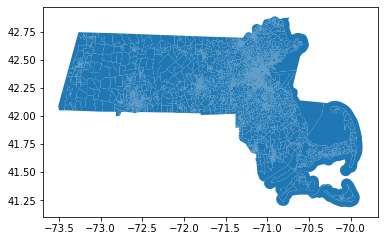

In [27]:
st=OpenCity.US_State(state_fips, year=2018, geom_type=geom_type)
st.get_geometry()
# st.remove_non_urban_zones()
st.get_lodes_data( include=['wac', 'rac', 'od'])
st.add_lodes_cols_to_shape()
st.geom.plot()

In [28]:
st.subset_geom_by_distance(centre_x_y=[geogrid.x_centroid.mean(), geogrid.y_centroid.mean()], 
                                   radius=reference_radius, name='reference_area')

st.subset_geom_by_distance(centre_x_y=[geogrid.x_centroid.mean(), geogrid.y_centroid.mean()], 
                                   radius=model_radius, name='model_area')

st.geom=assign_sim_area(gpd.GeoDataFrame(geogrid), st.geom)

	 Subsetting zones by distance
	 Subsetting zones by distance


In [29]:
zones=st.geom.rename(columns={col: 'area' for col in st.geom.columns if 'ALAND' in col})

In [30]:
zones.loc[zones['model_area']].to_file('tables/{}/zones.geojson'.format(table_name), driver='GeoJSON')

In [31]:
simpop_df=st.lodes_to_pop_table(
    model_subset_name='model_area', sim_subset_name='sim_area')
simpop_df.to_csv('tables/{}/simpop_df.csv'.format(table_name), index=False)

Using 2453 of 1511197 rows in OD data
0 of 2453


In [32]:
geogrid.to_file('tables/{}/geogrid.geojson'.format(table_name), driver='GeoJSON')